In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import parser_arguments
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
from math import ceil
from numpy import savetxt

# Set defaults

In [3]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
# chip_names = ["ET2_W15 3-4 230V"]
# chip_fignames = ["ET2_W15 3-4 230V"]
# chip_names = ["ET2_EPIR_Pair4"]
# chip_fignames = ["EPIR Pair 4"]
chip_names = ["ET2p01_BareBoard5"]
chip_fignames = ["ET2p01_BareBoard5"]
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: /dev/ttyACM0'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_addresses = [0x60]
ws_addresses = [None, None, None, None]

# fig_outdir = Path('../ETROC-figures')
fig_outdir = Path('/media/daq/X9/SEUApril2024/ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# histdir = Path('../ETROC-History')
histdir = Path('/media/daq/X9/SEUApril2024/ETROC-History')
histdir.mkdir(exist_ok=True)

# Make i2c_connection class object

In [4]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,ws_addresses,chip_names,[("1","1"),("1","1"),("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [5]:
# (WS Prep Pixel and Peri) - (Set Chip Offsets to 10) - (disable & auto_cal all pixels) - (auto_TH_CAL) - (disable default all pixels) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100101')
# i2c_conn.config_chips('00001111') # disable and more fun things
# i2c_conn.config_chips('00000100') # set basic peripherals
# i2c_conn.config_chips('00010000') # calibrate only
# i2c_conn.config_chips('00000001') # pixel ID check (I2C check)
# i2c_conn.config_chips('10000000') # ws init
# i2c_conn.disable_all_pixels(chip_address=chip_addresses[1])

Passed pixel check for chip: 0x60
Peripherals set for chip: 0x60
Disabled pixels for chip: 0x60
Disabled pixels (no change in DAC) for chip: 0x60


Calibrating row: 100%|██████████| 16/16 [01:26<00:00,  5.41s/it]

Auto calibration finished for chip: 0x60


## Set power mode to high if currents are too low

In [ ]:
full_col_list, full_row_list = np.meshgrid(np.arange(16),np.arange(16))
full_scan_list = list(zip(full_row_list.flatten(),full_col_list.flatten()))
for address in chip_addresses:
    i2c_conn.set_power_mode_scan_list(address, full_scan_list, 'high')

## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [6]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

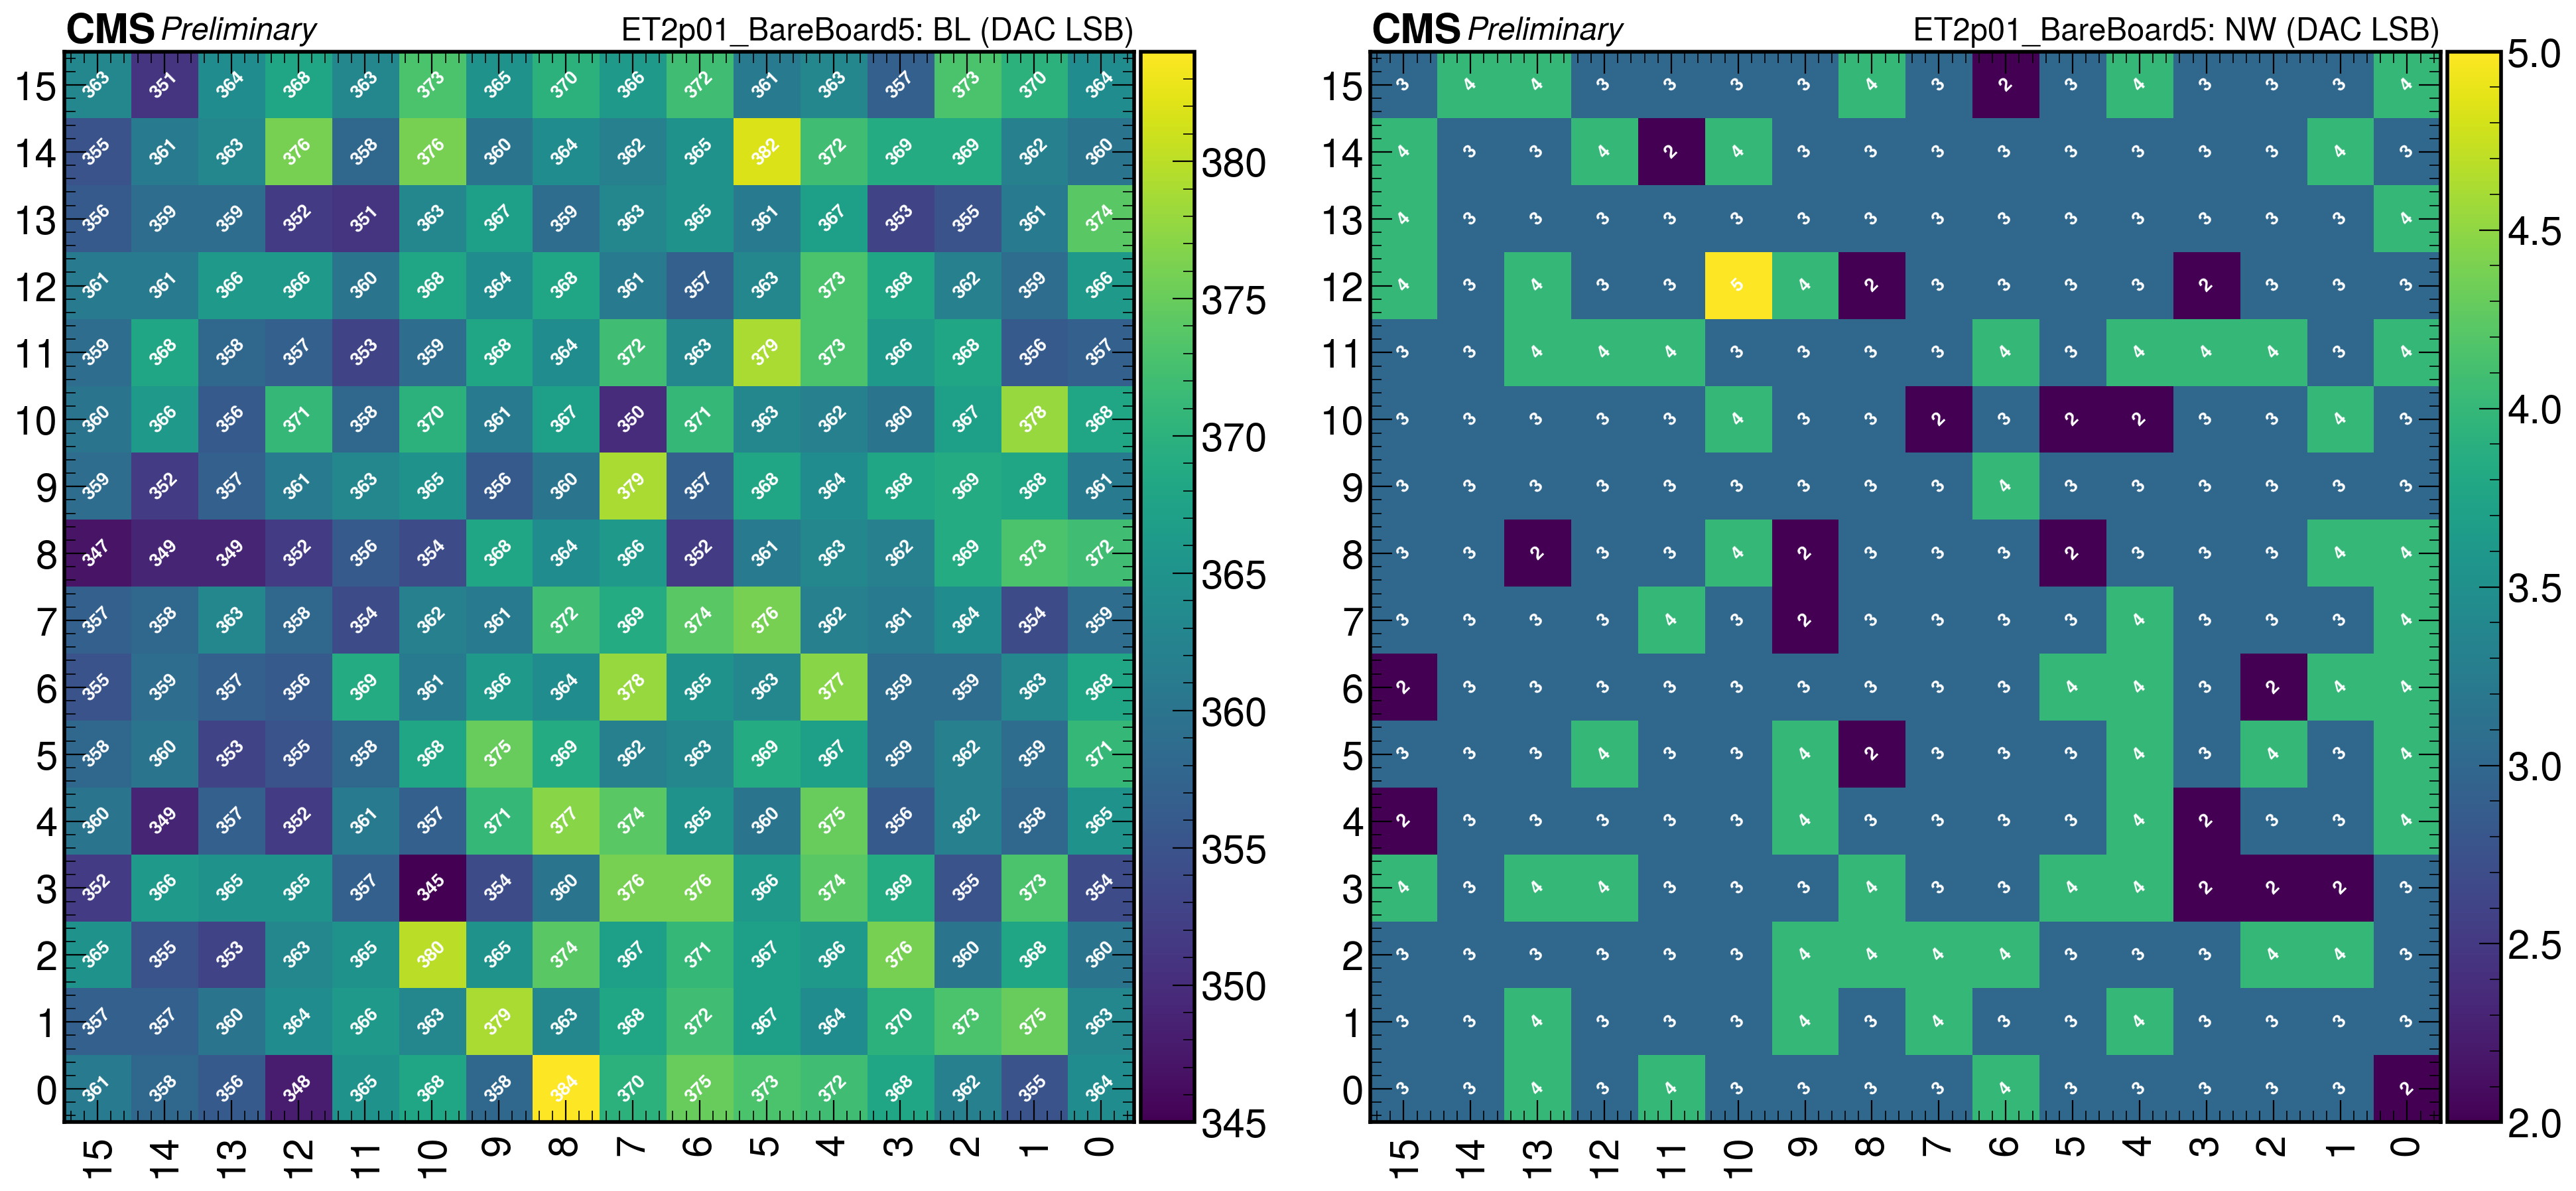

In [7]:
histfile = histdir / 'BaselineHistory.sqlite'
i2c_conn.save_baselines(chip_fignames,fig_path,histdir,histfile)

In [8]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.load_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.load_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [9]:
# row_list = [15, 15, 15, 15]
# col_list = [6, 7, 8, 9]
# row_list = [14, 14, 14, 14]
# col_list = [6, 7, 8, 9]
# row_list = [9, 3, 12]
# col_list = [3, 8, 11]
# row_list = [15, 15]
# col_list = [6, 9]
row_list = [14, 14, 15, 15]
col_list = [6, 9, 6, 9]
# row_list = [14, 14, 14, 14, 15, 15, 15, 15]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9]
# col_list = np.arange(16)
# row_list = np.full_like(col_list,12)
# row_list = np.full_like(col_list,13)
# col_list = [10, 13, 7, 4, 10, 13, 7, 4]
# row_list = [12, 12, 12, 12, 13, 13, 13, 13]

scan_list = list(zip(row_list, col_list))

# col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
# scan_list = list(zip(row_list.flatten(),col_list.flatten()))

print(scan_list)

[(14, 6), (14, 9), (15, 6), (15, 9)]


### Enable pixels of Interest

In [10]:
i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn=True,Bypass_THCal=True,specified_addresses=chip_addresses[:],power_mode='high',verbose=False)

100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


### Set offset for all boards

In [11]:
offset = 0x0f
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    i2c_conn.set_chip_offsets(chip_address, chip_name, offset=offset, chip=chip, pixel_list=scan_list, verbose=False)
    del chip

Offset set to 0xf for chip: 0x60


#### Set QSel or TH_offset for all boards

In [12]:
# offset = 0x0f
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("QSel", format(0x19, '05b'), chip)
        # i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '1', chip)
    del row_indexer_handle, column_indexer_handle, chip
time.sleep(2)

Operating on chip 0x60 Pixel (14,6)
Operating on chip 0x60 Pixel (14,9)
Operating on chip 0x60 Pixel (15,6)
Operating on chip 0x60 Pixel (15,9)


### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate FC for all I2C

In [13]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

Reset Global Readout done for chip: 0x60
asyAlignFastcommand action done for chip: 0x60


# Calibrate PLL

In [14]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

PLL Calibrated for chip: 0x60


# Disconnect I2C Device

## DO THIS IF YOU PLAN TO DO NOISE STUDIES

In [ ]:
del i2c_conn